# WAW ML5 Tutorial - Hyperparameter Optimization - Part 2

<img src='https://raw.githubusercontent.com/DLR-SC/Hyperparameter_tutorial/master/img/WAW_Tutorial_Title.png' width=500px>


In [9]:
%matplotlib inline
import talos

## Overview

The aim of the 2nd tutorial is the following:

* Introduction of Talos
* Use Talos for machine-assisted hyperparameter optimization of the Boston house price problem (1st Jupyter notebook)
* Give general guidelines for hyperparamter optimization

## 1. Introduction of Talos <a name="one"></a> 

### Start (iteration 0) with the original Keras code 

We first start with the code that we have already used in the first notebook

In [10]:
from keras.datasets import boston_housing

# load the data
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

# data normalization
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### Model preparation

Talos works with any Keras model, without changing the structure of the model in any way.  
The only difference in the Keras model is that a parameter is not set explicitly as before, e.g.

<pre><code> model.add(layers.Dense(32, activation='relu'))    </code></pre>

but instead taken from a dictionary, e.g.

<pre><code>
params = {'number_of_neurons' : [4, 6, 7, 8], 'activation' : ['relu'] }

model.add(layers.Dense(params['number_of_neurons'], activation=params['activation']))    
</code></pre>

Afterwards, this dictionary and the model will be passed to Talos. In the dictionary we have 
three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as None.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

## Tasks ## 
__Excercise 1:__
 - Create a Python dictionary that contains at least the following entries:
    * 'number_of_layers' : 1, 2
    * 'number_of_neurons' : 8, 16, 32, 64
    * 'dropout_value' : None, 0.1, 0.2
    * 'optimizer' : 'Adam', 'rmsprop'
    * 'batch_size': 1, 2, 4, 8 
    * 'epoch_number' : 10, 20, 40, 80
    * anything that you want to modify further (e.g. learning_rate, activation_function, loss_function, ...)
 - What is the number of different hyperparameter configurations that is considered?

In [11]:
# missing import statements
from keras.optimizers import Adam, rmsprop
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

# parameter dictionary
param = {'number_of_layers' : [1, 2],
         'number_of_neurons' : [8, 16, 32, 64],
         'epoch_number' : [10, 20, 40, 80],
         'dropout_value' : [None, 0.1, 0.2],
         'optimizer' : ['Adam', 'rmsprop'],
         'batch_size' : [1, 2, 4, 8]}


## Tasks ## 
__Excercise 2:__
 - Modify your original Keras model (Jupyter notebook 1) such that it uses uses the values from a 
 dictionary 'p'.

In [12]:
from keras import models
from keras import layers

def build_better_model(train_data, train_targets, val_data, val_targets, p):
    model = models.Sequential()
    
    # replace the hyperparameter inputs with references to dictionary p 
    model.add(layers.Dense(p['number_of_neurons'], activation='relu',
                           input_shape=(train_data.shape[1],)))
    
    if p['number_of_layers'] >= 2:
        model.add(layers.Dense(p['number_of_neurons'], activation='relu'))
    
    if p['dropout_value'] is not None:
        model.add(layers.Dropout(p['dropout_value']))
        
    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    
    # make sure history object is returned by model.fit()
    history = model.fit(train_data, train_targets, epochs=p['epoch_number'], batch_size=p['batch_size'], verbose=0)
    
    return history, model

## 2. Use Talos for hyperparameter optimization <a name="two"></a> 

This part is quite simple. The Talos experiment just uses the <code> Scan()<\code> command. In the following,
we will investigate different arguments for this routine. However, it there are only four necessary arguments
that are required:
* train_data (often known as 'x')
* train_targets (often known as 'y')
* params (the dictionary 'param' that we have created before)
* model (the 'build_model' that we also have created before)

In [13]:
scan_object = talos.Scan(x=train_data,
                         y=train_targets,
                         model=build_better_model,
                         experiment_name='find_optimal_params',
                         params=param,
                         round_limit=10)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:08<01:12,  8.03s/it]

 20%|██        | 2/10 [00:14<01:00,  7.51s/it]

 30%|███       | 3/10 [00:19<00:47,  6.73s/it]

 40%|████      | 4/10 [00:31<00:51,  8.50s/it]

 50%|█████     | 5/10 [00:48<00:55, 11.09s/it]

 60%|██████    | 6/10 [00:50<00:32,  8.17s/it]

 70%|███████   | 7/10 [00:53<00:20,  6.70s/it]

 80%|████████  | 8/10 [01:01<00:14,  7.12s/it]

 90%|█████████ | 9/10 [01:06<00:06,  6.32s/it]

100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


### 5. Access the results through the <code>Scan</code> object <a name="five"></a> 

In [7]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

experiment_name                    iris
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            11/12/19/16:50
x_shape                        (150, 4)
y_shape                        (150, 3)
dtype: object

In addition to statistics and meta-data related with the Scan, the used data (x and y) together with the saved model and model weights for each hyperparameter permutation is stored in the Scan object. 

In [8]:
# accessing the saved models
scan_object.saved_models

# accessing the saved weights for models
scan_object.saved_weights

[[array([[-0.00723678,  0.37863952,  0.1209296 ,  0.08094662],
         [-0.36644322,  0.22617362, -0.64746004, -0.8585334 ],
         [-0.04812884, -0.32430816, -0.56863886, -0.19977432],
         [ 0.5128588 , -0.48369992, -0.6818095 , -0.62469643]],
        dtype=float32),
  array([ 0.        , -0.12437053,  0.        ,  0.        ], dtype=float32),
  array([[-0.4129702 ,  0.2798705 , -0.7581575 ],
         [-0.6470166 , -0.6433501 , -0.9038856 ],
         [-0.1842491 ,  0.16785908, -0.62306666],
         [ 0.15558195, -0.1780613 , -0.10743612]], dtype=float32),
  array([ 0.00209298, -0.08639025,  0.10433408], dtype=float32)],
 [array([[-0.7909057 , -0.15463507, -0.6294545 , -0.40553808],
         [ 0.3059022 ,  0.26878148, -0.05365068, -1.0242589 ],
         [ 0.8258557 , -0.02296412, -0.38919878,  1.1587079 ],
         [-0.53994244, -0.77470785, -0.6885388 ,  2.4323356 ]],
        dtype=float32),
  array([-0.02792484, -0.20996667,  0.        , -0.99939865], dtype=float32),
  array

The Scan object can be further used, and is required, as input for Predict(), Evaluate(), and Deploy(). More about this in the corresponding sections below.

### 6. Analysing the Scan results with <code>Reporting()</code> <a name="six"></a> 

In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object. 

In [10]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [11]:
# access the dataframe with the results
analyze_object.data

,round_epochs,val_loss,val_acc,loss,acc,batch_size,dropout,epochs,first_neuron,last_activation,loss,lr,optimizer,weight_regulizer
0,200,1.032670,0.622222,1.050516,0.523810,4,0.16,200,4,softmax,categorical_crossentropy,0.10,<class 'keras.optimizers.Adam'>,None
1,200,0.139562,0.955556,0.227370,0.961905,2,0.04,200,4,softmax,categorical_crossentropy,5.05,<class 'keras.optimizers.Adam'>,None
2,200,0.067544,0.955556,0.197836,0.923810,3,0.24,200,32,softmax,categorical_crossentropy,6.04,<class 'keras.optimizers.Nadam'>,None


In [12]:
# get the number of rounds in the Scan
analyze_object.rounds()

# get the highest result for any metric
analyze_object.high('val_acc')

# get the round with the best result
analyze_object.rounds2high('val_acc')

# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss'])

round_epochs         NaN
val_acc        -0.997755
batch_size      0.830592
dropout         0.047916
epochs               NaN
first_neuron   -0.556881
lr             -0.996029
Name: val_loss, dtype: float64

In addition to the key obsevations, several useful plots are available for analysis of the results.

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


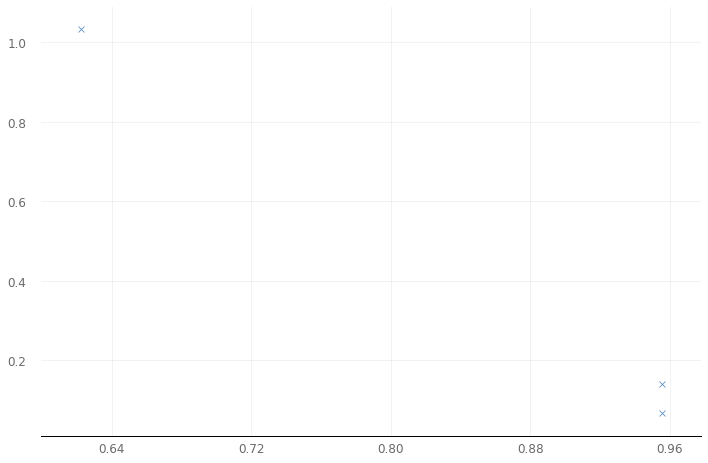

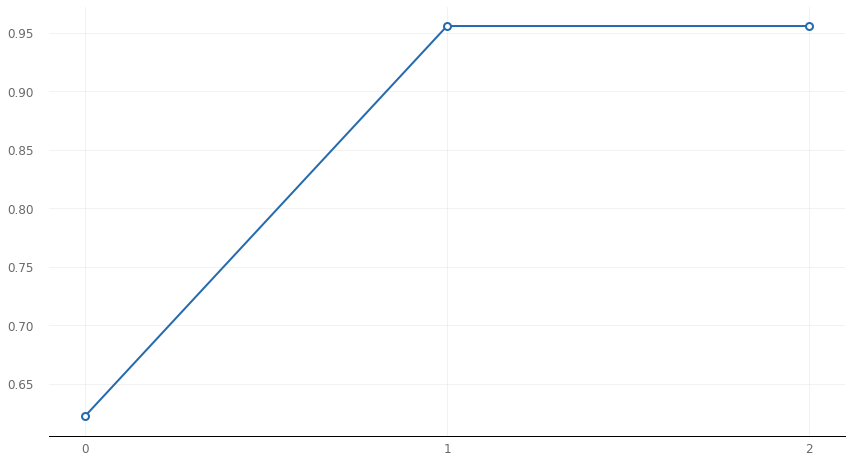

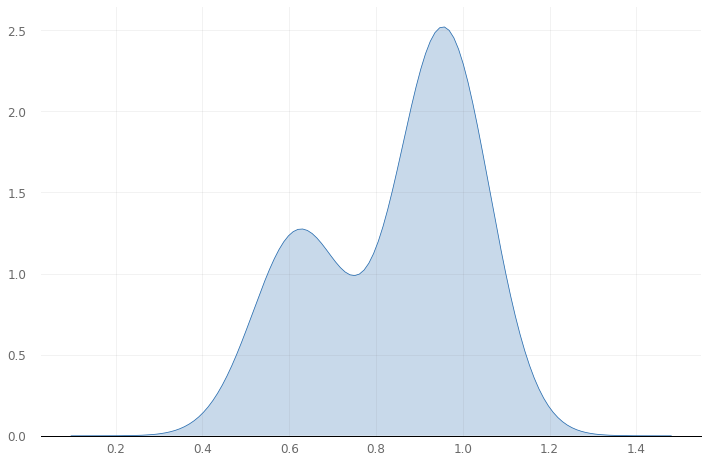

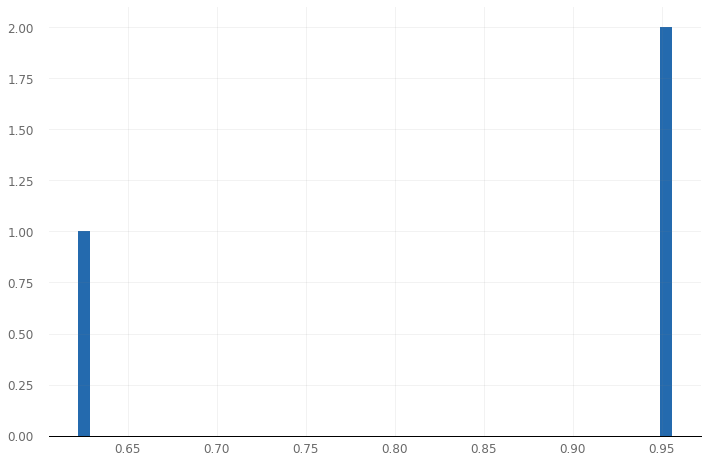

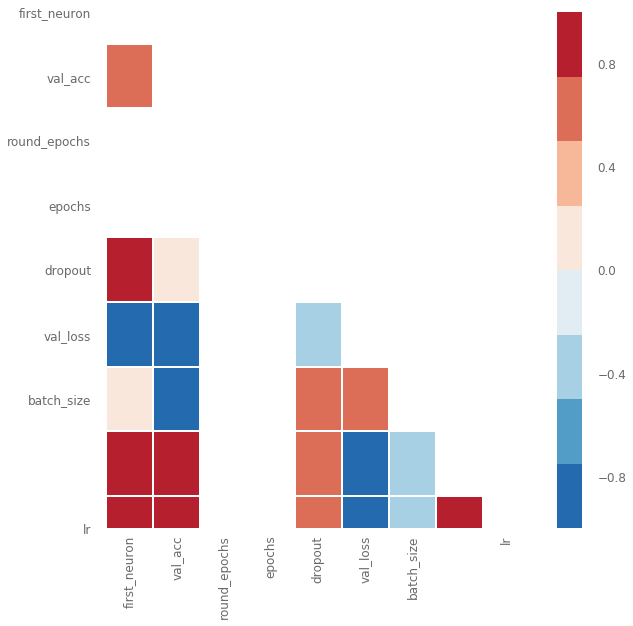

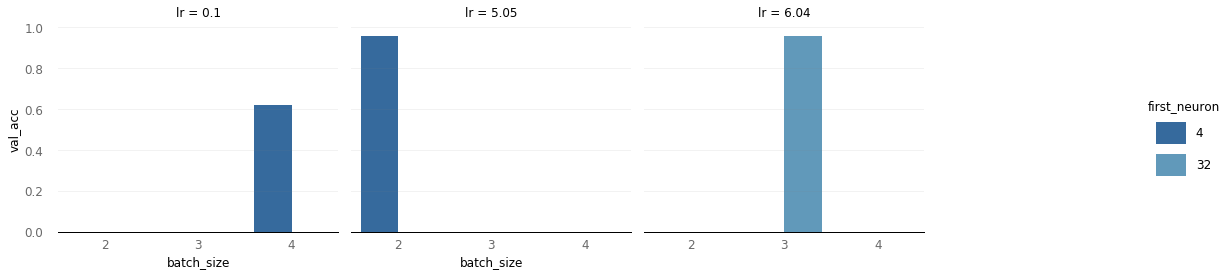

In [13]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_acc', 'val_loss')

# line plot
analyze_object.plot_line('val_acc')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_acc')

# a simple histogram
analyze_object.plot_hist('val_acc', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

### 7. Evaluating Models with <code>Evaluate()</code> <a name="seven"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [14]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(x, y, folds=10, metric='val_acc', task='multi_label')

[1.0,
 0.9440559440559441,
 0.8777777777777778,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9433551198257081,
 1.0,
 1.0]

Once a sufficiently performing model have been found, a deployment package can be easily created.

### 8. Deploying Models with <code>Deploy()</code> <a name="eight"></a> 

Once the right model or models have been found, you can create a deployment package with <code>Deploy()</code> which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of: 

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

The <code>Deploy</code> package can be easily restored with <code>Restore()</code> which is covered in the next section.

In [15]:
talos.Deploy(scan_object=scan_object, model_name='iris_deploy', metric='val_acc');

Deploy package iris_deploy have been saved.


### 9. Restoring Models with <code>Restore()</code> <a name="nine"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [16]:
iris = talos.Restore('iris_deploy.zip')

The <code>Restore</code> object now consists of the assets from the Scan object originally associated with the experiment, together with the model that had been picked as 'best'. The model can be immediately used for making prediction, or use in any other other way Keras model objects can be used.

In [17]:
# make predictions with the model
iris.model.predict(x)

array([[8.99947166e-01, 9.97709632e-02, 2.81914050e-04],
       [9.04120057e-10, 8.54317784e-01, 1.45682216e-01],
       [8.99947166e-01, 9.97709632e-02, 2.81914050e-04],
       [6.67008254e-18, 2.08236560e-01, 7.91763484e-01],
       [6.90926584e-07, 9.49802279e-01, 5.01970612e-02],
       [8.99947166e-01, 9.97709632e-02, 2.81914050e-04],
       [6.61923638e-15, 4.41949427e-01, 5.58050573e-01],
       [8.99947166e-01, 9.97709632e-02, 2.81914050e-04],
       [6.89416483e-26, 1.52990678e-02, 9.84700918e-01],
       [5.46807072e-26, 1.47760203e-02, 9.85224009e-01],
       [8.99947166e-01, 9.97709632e-02, 2.81914050e-04],
       [8.99947166e-01, 9.97709632e-02, 2.81914050e-04],
       [1.20792322e-07, 9.32818770e-01, 6.71810433e-02],
       [5.39756156e-11, 7.82327592e-01, 2.17672408e-01],
       [5.99508758e-06, 9.65265155e-01, 3.47287878e-02],
       [4.82715742e-14, 5.23173571e-01, 4.76826400e-01],
       [4.56301594e-11, 7.77353287e-01, 2.22646758e-01],
       [8.99947166e-01, 9.97709

In addition, for book keeping purpose, and for simplicity of sharing models with team members and other stakeholders, various attributes are included in the <code>Restore</code> object:

In [18]:
# get the meta-data for the experiment
iris.details

,0,1
0,experiment_name,iris
1,random_method,uniform_mersenne
2,reduction_method,NaN
3,reduction_interval,50
4,reduction_window,20
5,reduction_threshold,0.2
6,reduction_metric,val_acc
7,complete_time,11/12/19/16:50
8,x_shape,"(150, 4)"
9,y_shape,"(150, 3)"


In [19]:
# get the hyperparameter space boundary
iris.params

{'lr': (0.1, 10, 10),
 'first_neuron': [4, 8, 16, 32, 64, 128],
 'batch_size': [2, 3, 4],
 'epochs': [200],
 'dropout': (0, 0.4, 10),
 'optimizer': [keras.optimizers.Adam, keras.optimizers.Nadam],
 'loss': ['categorical_crossentropy'],
 'last_activation': ['softmax'],
 'weight_regulizer': [None]}

In [ ]:
# sample of x and y data
iris.x
iris.y

In [20]:
# the results dataframe
iris.results

,round_epochs,val_loss,val_acc,loss,acc,batch_size,dropout,epochs,first_neuron,last_activation,loss.1,lr,optimizer,weight_regulizer,Unnamed: 15
0,200,1.032670,0.622222,1.050516,0.523810,4,0.16,200,4,softmax,categorical_crossentropy,0.10,<class 'keras.optimizers.Adam'>,NaN,0
1,200,0.139562,0.955556,0.227370,0.961905,2,0.04,200,4,softmax,categorical_crossentropy,5.05,<class 'keras.optimizers.Adam'>,NaN,1
2,200,0.067544,0.955556,0.197836,0.923810,3,0.24,200,32,softmax,categorical_crossentropy,6.04,<class 'keras.optimizers.Nadam'>,NaN,2



<img align=left src='https://img00.deviantart.net/920c/i/2014/137/a/2/pinkie_pie_thats_all_folks_by_dan232323-d7ipnd4.jpg' width=400>

Back to the repository page >> http://github.com/autonomio/talos